# Image Deblurring


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/carnotresearch/cr-sparse-evaluation/blob/master/comparison/pylops/image_deblurring.ipynb)

Please make sure that following libraries are installed to run the code in this notebook
- cr-sparse
- pylops
- scikit-image

In [4]:
from jax.config import config
config.update("jax_enable_x64", True)

In [5]:
import pylops
import numpy as np
import jax.numpy as jnp
from cr.sparse import lop
import cr.sparse as crs
import cr.sparse.vision as vision
import cr.sparse.sls as sls
import cr.sparse.geo as geo
from cr.sparse import metrics
import skimage.data

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
h_jax  = vision.kernel_gaussian((15,25), (8,4))
h_np = np.array(h_jax)

(-0.5, 24.5, 14.5, -0.5)

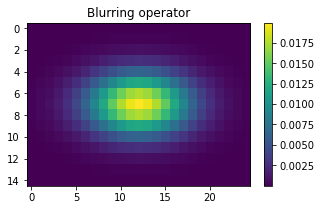

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h_jax)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight')

In [30]:
# kernel size (h x w)
h_np.shape

(15, 25)

In [9]:
offset = crs.arr_largest_index(h_jax)
offset

(DeviceArray(7, dtype=int64), DeviceArray(12, dtype=int64))

(500, 480)

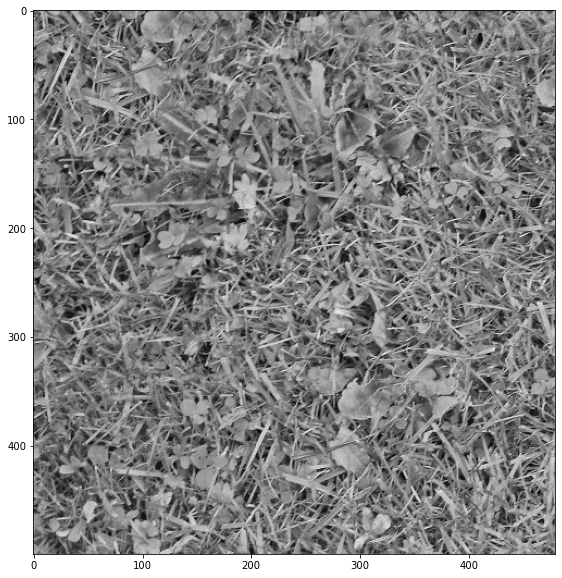

In [10]:
image_np = skimage.data.grass()
# cut the image a little bit to make use of padding later
image_np = image_np[:500, :480]
image_jax = jnp.array(image_np)
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image_np, cmap=plt.cm.gray)
image_np.shape

In [11]:
# The blur operator using CR-Sparse
Blur_jax = lop.convolve2D(image_jax.shape, h_jax, offset=offset)
Blur_jax = lop.jit(Blur_jax)

In [12]:
Blur_np = pylops.signalprocessing.Convolve2D(image_np.size, h_np, dims=image_np.shape, offset=offset)

In [13]:
blurred_np = Blur_np.matvec(image_np.flatten()).reshape(image_np.shape)

In [14]:
blurred_jax = Blur_jax.times(image_jax)

In [15]:
np.allclose(blurred_np, blurred_jax)

True

In [16]:
blur_np_time = %timeit -o Blur_np.matvec(image_np.flatten()).reshape(image_np.shape)

6.63 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
blur_jax_time = %timeit -o Blur_jax.times(image_jax)

1.64 ms ± 5.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
gain = blur_np_time.best / blur_jax_time.best
print(gain)

4.03418337928398


In [19]:
print(metrics.peak_signal_noise_ratio(image_jax, blurred_jax), 'dB')

18.43464314401944 dB


Text(0.5, 1.0, 'After blurring')

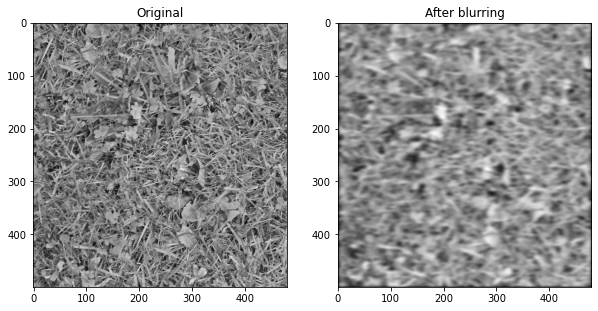

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image_jax, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred_jax, cmap=plt.cm.gray)
ax[1].set_title('After blurring')

In [21]:
x0 = jnp.zeros_like(blurred_jax)
sol = sls.lsqr_jit(Blur_jax, blurred_jax, x0, max_iters=11)
deblurred_jax = sol.x
print(metrics.peak_signal_noise_ratio(image_jax, deblurred_jax), 'dB')

19.79312598449172 dB


In [22]:
print(sol)

x: (500, 480)
A_norm: 2.369799334421989
A_cond: 16.592094521926075
x_norm: 59387.282501507194
r_norm: 390.6092200111112
atr_norm: 93.52089514863773
iterations: 11
n_times: 11
n_trans: 11


Text(0.5, 1.0, 'After deblurring')

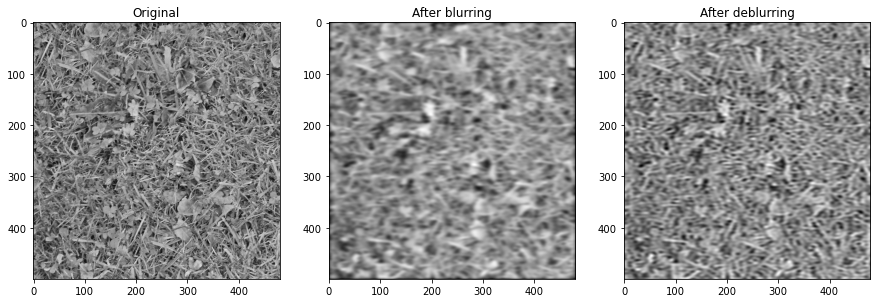

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(image_jax, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred_jax, cmap=plt.cm.gray)
ax[1].set_title('After blurring')
ax[2].imshow(deblurred_jax, cmap=plt.cm.gray)
ax[2].set_title('After deblurring')

In [24]:
x0_np = np.array(x0).flatten()
result_np = pylops.optimization.solver.lsqr(Blur_np, blurred_np.flatten(), x0_np, niter=10)
x, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var, cost= result_np
print(f'itn={itn} \n')
deblurred_np = x.reshape(image_np.shape)
print(metrics.peak_signal_noise_ratio(image_np, deblurred_np), 'dB')

itn=10 

19.79312598449172 dB


In [25]:
np.allclose(deblurred_np, deblurred_jax)

True

In [26]:
lsqr_np_time = %timeit -o pylops.optimization.solver.lsqr(Blur_np, blurred_np.flatten(), x0_np, niter=10)

237 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
lsqr_jax_time = %timeit -o sls.lsqr_jit(Blur_jax, blurred_jax, x0, max_iters=11).x.block_until_ready()

39.3 ms ± 98.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
gain = lsqr_np_time.best / lsqr_jax_time.best
print(gain)

6.029755256726059
